In [129]:
from CO2xSWV import fetch_data_from_NEON_API
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import multiprocessing
from dataclasses import dataclass
import xarray as xr
from dask import delayed
import dask

multiprocessing.cpu_count()

16

In [48]:
sitecodes = ['BART', 'ABBY', 'TEAK']
productcodes = ['DP1.00095.001', 'DP1.00094.001','DP1.00041.001']
daterange = ['2015-01', '2020-11']
fetch_data_from_NEON_API(sitecodes, productcodes, daterange=daterange)
# optimize dask for cyverse

[########################################] | 100% Completed | 33min 10.6s


In [219]:
# glob files for the site
data_path='/home/jovyan/NEON/CO2xSWV_data'
site = 'TEAK'
soil_CO2 = glob.glob(f'{data_path}/*{site}*SCO2C_1_minute*.csv')
soil_H2O = glob.glob(f'{data_path}/*{site}*SWS_1_minute*.csv')
soil_T   = glob.glob(f'{data_path}/*{site}*ST_1_minute*.csv')
# make lists with date, and files for that date
sc = set([f.split('.')[-4] for f in soil_CO2])
sw = set([f.split('.')[-4] for f in soil_H2O])
st = set([f.split('.')[-4] for f in soil_T])
# find dates present in all data products
dates = list(sc & sw & st)
dates.sort()
# make seperate lists of each product for the dates where all are present
c = []
w = []
t = []
for date in dates:
    c = c + [f for f in soil_CO2 if date in f]
    w = w + [f for f in soil_H2O if date in f]
    t = t + [f for f in soil_T if date in f]
# Now we have all of the files for the site in seperate lists by product

In [220]:
# find the HOR-VER combinations present for all dates at site
horvers = []
for date in dates:
    #find files for the date
    cc = [f for f in c if date in f]
    ww = [f for f in w if date in f]
    tt = [f for f in t if date in f]
    #find HOR and VER combinations for the date (e.g. '003501')
    ccc = [''.join(f.split('.')[6:8]) for f in cc]
    www = [''.join(f.split('.')[6:8]) for f in ww]
    ttt = [''.join(f.split('.')[6:8]) for f in tt]
    horver = list(set(ccc) & set(www) & set(ttt))
    horvers.append(horver)
    
horver = set(horvers[0])   
for hv in horvers[1:]:
    horver = horver & set(hv)
horver = list(horver)

hor = list(set([hv[:3] for hv in horver]))
hor.sort()
hor_ver = [[hv[:3], hv[3:]] for hv in horver]
horver = {key : [] for key in hor}
for key, val in hor_ver:
    horver[key].append(val)
#for val in horver.values():
 #   val.sort()
# horver is a dict all HOR-VER combinations available at eacg site
# its like {Hor : [z1, z2,...]}

In [221]:
horver

{'001': ['502', '501', '503'],
 '002': ['503', '502', '501'],
 '003': ['502', '501', '503'],
 '004': ['501', '502', '503'],
 '005': ['502', '501']}

Cell below not working, returns none.  Loop never runs through to end (would print 'oi')

the loop never concats its products eaither.  

In [228]:
def make_dfs(hor, ver, dates):
    hour = None
    hv_glob = hor + '.' + ver + '.' + ('[0-9]' * 3 ) + '.'
    for date in dates:
        # glob the filenames, only one gets globbed for each
        co2 = glob.glob(f'{data_path}/*{site}*{hv_glob}*SCO2C_1_minute.{date}*.csv')[0]
        h2o = glob.glob(f'{data_path}/*{site}*{hv_glob}*SWS_1_minute.{date}*.csv')[0]
        t   = glob.glob(f'{data_path}/*{site}*{hv_glob}*ST_1_minute.{date}*.csv')[0]
        
        # make C02 df
        co2 = pd.read_csv(co2, parse_dates=True, index_col='startDateTime')
        # Fail and pass columns are redundent, we will use the fails
        drops = [col for col in list(co2.columns) if 'Pass' in col]
        co2.drop(drops, axis='columns', inplace=True)
        # drop columns with bad quality flags
        x = len(co2)
        co2 = co2.loc[co2.finalQF == 0] 
        if (x - len(co2)) / x > 0.8: continue
        # now drop quality metric columns
        qm = [col for col in list(co2.columns) if 'QM' in col]
        qm = qm + [col for col in list(co2.columns) if 'QF' in col] + ['endDateTime']
        co2.drop(qm, axis='columns', inplace=True)
        #this following step should not be needed, but just in case
        co2.dropna(inplace=True)
        
        h2o = pd.read_csv(h2o, parse_dates=True, index_col='startDateTime')
        # Fail and pass columns are redundent, we will use the fails
        drops = [col for col in list(h2o.columns) if 'Pass' in col]
        h2o.drop(drops, axis='columns', inplace=True)
        # drop columns with bad quality flags
        x = len(h2o)
        h2o = h2o.loc[(h2o.VSWCFinalQF == 0) & (h2o.VSICFinalQF == 0)]
        if (x - len(h2o)) / x > 0.8: continue
        # now drop quality metric columns
        qm = [col for col in list(h2o.columns) if 'QM' in col]
        qm = qm + [col for col in list(h2o.columns) if 'QF' in col] + ['endDateTime']
        h2o.drop(qm, axis='columns', inplace=True)
        #this following step should not be needed, but just in case
        h2o.dropna(inplace=True)
        
        soil_T = pd.read_csv(t, parse_dates=True, index_col='startDateTime')
        # Fail and pass columns are redundent, we will use the fails
        drops = [col for col in list(soil_T.columns) if 'Pass' in col]
        soil_T.drop(drops, axis='columns', inplace=True)
        # drop columns with bad quality flags
        x = len(soil_T)
        soil_T = soil_T.loc[soil_T.finalQF == 0]
        if (x - len(soil_T)) / x > 0.8: continue
        # now drop quality metric columns
        qm = [col for col in list(soil_T.columns) if 'QM' in col]
        qm = qm + [col for col in list(soil_T.columns) if 'QF' in col] + ['endDateTime']
        soil_T.drop(qm, axis='columns', inplace=True)
        #this following step should not be needed, but just in case
        soil_T.dropna(inplace=True)
        
        co2 = co2.merge(h2o, left_index=True, right_index=True)
        co2 = co2.merge(soil_T, left_index=True, right_index=True)
        
        hourCO2 = co2.soilCO2concentrationMean.resample('1h').mean().dropna()
        hourCO2_soilCO2concentrationStdErMean = co2.soilCO2concentrationStdErMean.resample('1h').mean().dropna()
        
        hourH2O = co2.VSWCMean.resample('1h').mean().dropna()
        hourH2O_VSWCStdErMean = co2.VSWCStdErMean.resample('1h').mean().dropna()
        
        hourSal = co2.VSICMean.resample('1h').mean().dropna()
        hourSal_VSICStdErMean = co2.VSICStdErMean.resample('1h').mean().dropna()
        hourT = co2.soilTempMean.resample('1h').mean().dropna()
        hourT_StdErMean = co2.soilTempStdErMean.resample('1h').mean().dropna()
        
        data = {'CO2'          : hourCO2,
                'CO2_sem'      : hourCO2_soilCO2concentrationStdErMean,
                'H2O'          : hourH2O,
                'H2O_sem'      : hourH2O_VSWCStdErMean,
                'T'            : hourT,
                'T_sem'        : hourT_StdErMean,
                'Salinity'     : hourSal,
                'Salinity_sem' : hourSal_VSICStdErMean}
        hour = pd.concat(data, axis=1)

    return(hour)

In [229]:
# make a hourly df for each hor
#@delayed
lil_dates = dates[:3]

for hor, vers in horver.items():
    for ver in vers:
        hour = make_dfs(hor, ver, lil_dates)
            


In [231]:
hour

In [ ]:
soilTempStdErMean','soilTempVariance'   'soilCO2concentrationVariance', 'soilCO2concentrationStdErMean'   'VSWCVariance', 'VSWCStdErMean' 
'VSICVariance',
 'VSICStdErMean'

In [203]:
#!ls NEON/CO2xSWV_data |grep SWS

In [204]:
bones = data_path + '/' + 'NEON.D01.BART.DP1.00094.001.001.501.001.SWS_1_minute.2016-11.expanded.20200619T095925Z.csv'

In [205]:
df = pd.read_csv(bones, parse_dates=True, index_col='startDateTime')

In [206]:
list(df.columns)

['endDateTime',
 'VSWCMean',
 'VSWCMinimum',
 'VSWCMaximum',
 'VSWCVariance',
 'VSWCNumPts',
 'VSWCExpUncert',
 'VSWCStdErMean',
 'VSWCRangeFailQM',
 'VSWCRangePassQM',
 'VSWCRangeNAQM',
 'VSWCPersistenceFailQM',
 'VSWCPersistencePassQM',
 'VSWCPersistenceNAQM',
 'VSWCStepFailQM',
 'VSWCStepPassQM',
 'VSWCStepNAQM',
 'VSWCNullFailQM',
 'VSWCNullPassQM',
 'VSWCNullNAQM',
 'VSWCGapFailQM',
 'VSWCGapPassQM',
 'VSWCGapNAQM',
 'VSWCSpikeFailQM',
 'VSWCSpikePassQM',
 'VSWCSpikeNAQM',
 'VSWCValidCalFailQM',
 'VSWCValidCalPassQM',
 'VSWCValidCalNAQM',
 'VSWCAlphaQM',
 'VSWCBetaQM',
 'VSWCFinalQF',
 'VSWCFinalQFSciRvw',
 'VSICMean',
 'VSICMinimum',
 'VSICMaximum',
 'VSICVariance',
 'VSICNumPts',
 'VSICExpUncert',
 'VSICStdErMean',
 'VSICRangeFailQM',
 'VSICRangePassQM',
 'VSICRangeNAQM',
 'VSICPersistenceFailQM',
 'VSICPersistencePassQM',
 'VSICPersistenceNAQM',
 'VSICStepFailQM',
 'VSICStepPassQM',
 'VSICStepNAQM',
 'VSICNullFailQM',
 'VSICNullPassQM',
 'VSICNullNAQM',
 'VSICGapFailQM',
 'VSIC

In [50]:
for idx in range(len(dates)):
    f = c[idx] 
    co2 = pd.read_csv(f, parse_dates=True, index_col='startDateTime')
    # Fail and pass columns are redundent, we will use the fails
    drops = [col for col in list(co2.columns) if 'Pass' in col]
    co2.drop(drops, axis='columns', inplace=True)
    # drop columns with bad quality flags
    x = len(co2)
    co2 = co2.loc[co2.finalQF == 0] 
    if (x - len(co2)) / x > 0.8: continue
    # now drop quality metric columns
    qm = [col for col in list(co2.columns) if 'QM' in col]
    qm = qm + [col for col in list(co2.columns) if 'QF' in col] + ['endDateTime']
    co2.drop(qm, axis='columns', inplace=True)
    #this following step should not be needed, but just in case
    co2.dropna(inplace=True)
    print(f'{idx} - 1')
    
    f = w[idx]
    h2o = pd.read_csv(f, parse_dates=True, index_col='startDateTime')
    # Fail and pass columns are redundent, we will use the fails
    drops = [col for col in list(h2o.columns) if 'Pass' in col]
    h2o.drop(drops, axis='columns', inplace=True)
    # drop columns with bad quality flags
    x = len(h2o)
    h2o = h2o.loc[(h2o.VSWCFinalQF == 0) & (h2o.VSICFinalQF == 0)]
    if (x - len(h2o)) / x > 0.8: continue
    # now drop quality metric columns
    qm = [col for col in list(h2o.columns) if 'QM' in col]
    qm = qm + [col for col in list(h2o.columns) if 'QF' in col] + ['endDateTime']
    h2o.drop(qm, axis='columns', inplace=True)
    #this following step should not be needed, but just in case
    h2o.dropna(inplace=True)
    print(f'{idx} - 2')

    f = t[idx]
    soil_T = pd.read_csv(f, parse_dates=True, index_col='startDateTime')
    # Fail and pass columns are redundent, we will use the fails
    drops = [col for col in list(soil_T.columns) if 'Pass' in col]
    soil_T.drop(drops, axis='columns', inplace=True)
    # drop columns with bad quality flags
    x = len(soil_T)
    soil_T = soil_T.loc[soil_T.finalQF == 0]
    if (x - len(soil_T)) / x > 0.8: continue
    # now drop quality metric columns
    qm = [col for col in list(soil_T.columns) if 'QM' in col]
    qm = qm + [col for col in list(soil_T.columns) if 'QF' in col] + ['endDateTime']
    soil_T.drop(qm, axis='columns', inplace=True)
    #this following step should not be needed, but just in case
    soil_T.dropna(inplace=True)
    print(f'{idx} - 3')
    
    print(list(co2.index)[0])
    co2 = co2.merge(h2o, left_index=True, right_index=True)
    co2 = co2.merge(soil_T, left_index=True, right_index=True)
    hourCO2 = co2.soilCO2concentrationMean.resample('1h').mean().dropna()
    hourH2O = co2.VSWCMean.resample('1h').mean().dropna()
    hourT = co2.soilTempMean.resample('1h').mean().dropna()
    data = {'CO2' : hourCO2,
            'H2O' : hourH2O,
            'T'   : hourT}
    hour = pd.concat(data, axis=1)
    
    if 'hourly' in globals():
        pd.concat([hourly, hour])
    else:
        hourly = hour
    print(f'{idx} complete df len = {len(hourly)}')

4 - 1
5 - 1
6 - 1
7 - 1
8 - 1
9 - 1
10 - 1
11 - 1
12 - 1
15 - 1
18 - 1
22 - 1
23 - 1
24 - 1
25 - 1
26 - 1
27 - 1
28 - 1
29 - 1
30 - 1
31 - 1
32 - 1
32 - 2
32 - 3
2019-06-01 00:00:00+00:00
32 complete df len = 304
33 - 1
34 - 1
35 - 1
35 - 2
35 - 3
2019-09-01 00:00:00+00:00
35 complete df len = 304
36 - 1
37 - 1
38 - 1
39 - 1
40 - 1
40 - 2
40 - 3
2020-02-01 00:00:00+00:00
40 complete df len = 304
41 - 1
43 - 1
44 - 1
45 - 1
46 - 1
46 - 2
46 - 3
2020-08-01 00:00:00+00:00
46 complete df len = 304
47 - 1
49 - 1


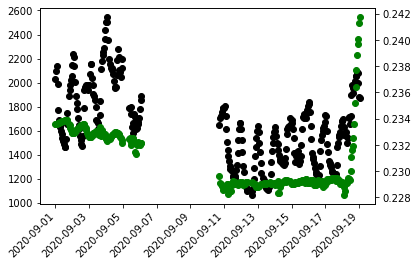

In [80]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(hourCO2.index, hourCO2, c='k')
ax2.scatter(hourH2O.index, hourH2O, c='g')
fig.autofmt_xdate(rotation=45)

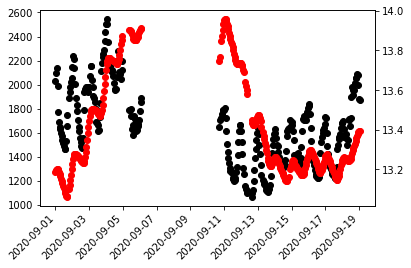

In [81]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(hourCO2.index, hourCO2, c='k')
ax2.scatter(hourT.index, hourT, c='r')
fig.autofmt_xdate(rotation=45)

Text(0.5, 0, 'CO2 (ppm?)')

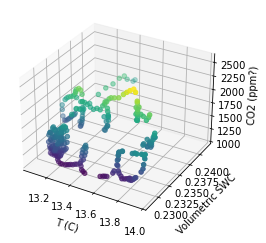

In [68]:

fig = plt.figure()
ax = plt.axes(projection='3d')

x = hourT
y = hourH2O
z = hourCO2

ax.scatter(x, y, z, c=z)

ax.set_xlabel('T (C)')
ax.set_ylabel('Volumetric SWC')
ax.set_zlabel('CO2 (ppm?)')

In [ ]:
for idx in range(len(dates)):
    f = c[idx] 
    co2 = pd.read_csv(f, parse_dates=True, index_col='startDateTime')
    # Fail and pass columns are redundent, we will use the fails
    drops = [col for col in list(co2.columns) if 'Pass' in col]
    co2.drop(drops, axis='columns', inplace=True)
    # drop columns with bad quality flags
    x = len(co2)
    co2 = co2.loc[co2.finalQF == 0] 
    if (x - len(co2)) / x > 0.8: continue
    # now drop quality metric columns
    qm = [col for col in list(co2.columns) if 'QM' in col]
    qm = qm + [col for col in list(co2.columns) if 'QF' in col] + ['endDateTime']
    co2.drop(qm, axis='columns', inplace=True)
    #this following step should not be needed, but just in case
    co2.dropna(inplace=True)
    print(f'{idx} - 1')
    
    f = w[idx]
    h2o = pd.read_csv(f, parse_dates=True, index_col='startDateTime')
    # Fail and pass columns are redundent, we will use the fails
    drops = [col for col in list(h2o.columns) if 'Pass' in col]
    h2o.drop(drops, axis='columns', inplace=True)
    # drop columns with bad quality flags
    x = len(h2o)
    h2o = h2o.loc[(h2o.VSWCFinalQF == 0) & (h2o.VSICFinalQF == 0)]
    if (x - len(h2o)) / x > 0.8: continue
    # now drop quality metric columns
    qm = [col for col in list(h2o.columns) if 'QM' in col]
    qm = qm + [col for col in list(h2o.columns) if 'QF' in col] + ['endDateTime']
    h2o.drop(qm, axis='columns', inplace=True)
    #this following step should not be needed, but just in case
    h2o.dropna(inplace=True)
    print(f'{idx} - 2')

    f = t[idx]
    soil_T = pd.read_csv(f, parse_dates=True, index_col='startDateTime')
    # Fail and pass columns are redundent, we will use the fails
    drops = [col for col in list(soil_T.columns) if 'Pass' in col]
    soil_T.drop(drops, axis='columns', inplace=True)
    # drop columns with bad quality flags
    x = len(soil_T)
    soil_T = soil_T.loc[soil_T.finalQF == 0]
    if (x - len(soil_T)) / x > 0.8: continue
    # now drop quality metric columns
    qm = [col for col in list(soil_T.columns) if 'QM' in col]
    qm = qm + [col for col in list(soil_T.columns) if 'QF' in col] + ['endDateTime']
    soil_T.drop(qm, axis='columns', inplace=True)
    #this following step should not be needed, but just in case
    soil_T.dropna(inplace=True)
    print(f'{idx} - 3')
    
    print(list(co2.index)[0])
    co2 = co2.merge(h2o, left_index=True, right_index=True)
    co2 = co2.merge(soil_T, left_index=True, right_index=True)
    hourCO2 = co2.soilCO2concentrationMean.resample('1h').mean().dropna()
    hourH2O = co2.VSWCMean.resample('1h').mean().dropna()
    hourT = co2.soilTempMean.resample('1h').mean().dropna()
    data = {'CO2' : hourCO2,
            'H2O' : hourH2O,
            'T'   : hourT}
    hour = pd.concat(data, axis=1)
    
    if 'hourly' in globals():
        pd.concat([hourly, hour])
    else:
        hourly = hour
    print(f'{idx} complete df len = {len(hourly)}')